<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install git+https://github.com/pvigier/perlin-numpy

  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-sizq1dj_
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-sizq1dj_
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Preparing metadata (setup.py) ... done


In [2]:
pip install noise

In [3]:
pip install tensorflow_addons

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
import numpy as np
from perlin_numpy import generate_perlin_noise_2d
import noise
from noise import pnoise2
from noise import snoise3
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


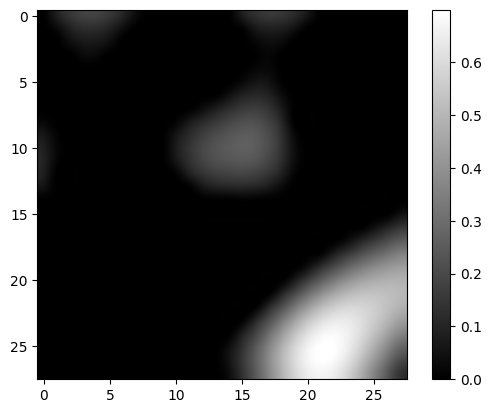

In [5]:
#np.random.seed(1)
noise = generate_perlin_noise_2d((28, 28), (2, 2))
noise = np.clip(noise,0,1)
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()

In [6]:


# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
#x_train = (x_train.astype("float32") - 127.5) / 127.5
#y_train = y_train.reshape(-1, 1)
x_train = (x_train.astype("float32")) / np.max(x_train)


# Example usage
image_index = 0  # Index of the image you want to retrieve
image = x_train[image_index]
print(image.shape)
print(x_train.shape[0])


(28, 28)
60000


In [7]:
print(np.max(x_train))

1.0


In [8]:
x_train2 = x_train[:100]
y_train2 = y_train[:100]

In [9]:
class AddNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, stddev, probability, **kwargs):
        super(AddNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev
        self.probability = probability

    def call(self, inputs, training=None):
        if training:

            if tf.random.uniform(()) < self.probability:
                perlin = generate_perlin_noise_2d((28, 28), (2, 2))
                perlin = tf.convert_to_tensor(perlin, dtype=tf.float32)
                perlin = tf.clip_by_value(perlin, 0, 1)
                perlin = tf.reshape(perlin, (28, 28, 1))
                noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
                output = inputs + noise * perlin
                return tf.clip_by_value(output, 0, 1)
            else:
                return inputs
        return inputs

In [10]:
class AddNoiseLayertest(tf.keras.layers.Layer):
    def __init__(self, stddev=.5, **kwargs):
        super(AddNoiseLayertest, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:

              perlin = generate_perlin_noise_2d((28, 28), (2, 2))
              perlin = tf.convert_to_tensor(perlin, dtype=tf.float32)
              perlin = tf.clip_by_value(perlin, 0, 1)
              perlin = tf.reshape(perlin, (28, 28, 1))
              noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
              output = inputs + noise * perlin
              return tf.clip_by_value(output, 0, 1)
        return inputs

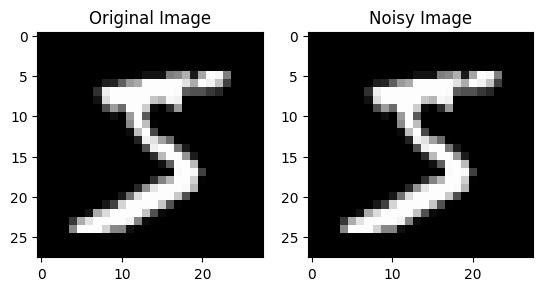

(28, 28, 1)


In [11]:
# Create a random 28x28 image tensor
image = x_train[0]
image = np.expand_dims(image,-1)
# Instantiate the RandomNoiseLayer
GaussianPerlinNoiseLayer = AddNoiseLayer(.5,.5)

# Pass the image through the layer
noisy_image = GaussianPerlinNoiseLayer(image,training=True)

# Display the original and noisy images
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')  # Display the original image
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(noisy_image), cmap='gray')  # Display the noisy image
plt.title('Noisy Image')
plt.show()

print(noisy_image.shape)

In [12]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.activation = tf.keras.activations.get(activation)

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')
        self.shortcut_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        shortcut = self.shortcut(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        x = tf.keras.layers.add([x, shortcut])
        x = self.activation(x)

        return x

In [13]:
class CustomFullAug(tf.keras.layers.Layer):
    def __init__(self, probability=.2,rot_factor=.2,height=.2,width=.2,stdev=.2):
        super(CustomFullAug, self).__init__()
        self.probability = probability

        self.rot_factor = rot_factor
        self.height = height
        self.width = width
        self.stdev = stdev
        self.flip_layer = tf.keras.layers.RandomFlip()
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=rot_factor)
        self.noise_layer = AddNoiseLayertest()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            #flipped_data = self.flip_layer(inputs, training=training)
            rotated_data = self.rotation_layer(inputs, training=training)
            zoomed_data = self.zoom_layer(rotated_data, training=training)
            noised = self.noise_layer(zoomed_data, training=training)
            return noised
        else:
            return inputs

In [14]:

class CustomFlipLayer(tf.keras.layers.Layer):
    def __init__(self, probability):
        super(CustomFlipLayer, self).__init__()
        self.probability = probability
        self.flip_layer = tf.keras.layers.RandomFlip()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            flipped_data = self.flip_layer(inputs, training=training)
            return flipped_data
        else:
            return inputs

In [15]:
class CustomRotationLayer(tf.keras.layers.Layer):
    def __init__(self, probability, factor):
        super(CustomRotationLayer, self).__init__()
        self.probability = probability
        self.factor = factor
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=factor)

    def call(self, inputs, training=True):
        if tf.random.uniform(()) < self.probability:
            rotated_data = self.rotation_layer(inputs, training=training)
            return rotated_data
        else:
            return inputs

In [16]:
class CustomZoomLayer(tf.keras.layers.Layer):
    def __init__(self, probability,height, width):
        super(CustomZoomLayer, self).__init__()
        self.probability = probability
        self.height = height
        self.width = width
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)

    def call(self, inputs, training=False):
        if tf.random.uniform(()) < self.probability:
            zoomed_data = self.zoom_layer(inputs, training=training)
            return zoomed_data
        else:
            return inputs

In [92]:
from keras.layers.serialization import activation


def build_generator():
    noise_shape = (28,28,1)
    noise = layers.Input(shape=noise_shape)
    input_digit = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 28*28)(input_digit)
    digit_embedding = layers.Reshape((28, 28, 1))(digit_embedding)


    x = layers.Concatenate()([noise, digit_embedding])


    x = layers.Conv2D(1, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(1, 2, strides=2, padding="same", activation="sigmoid")(x)



    model = tf.keras.models.Model(inputs=[noise, input_digit], outputs=x)
    return model

generator = build_generator()
generator.summary()



Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 1, 784)       7840        ['input_66[0][0]']               
                                                                                                  
 input_65 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape_27 (Reshape)           (None, 28, 28, 1)    0           ['embedding_23[0][0]']           
                                                                                           

In [93]:

def build_discriminator():
    input_image = layers.Input(shape=(28, 28, 1))
    digit_input = layers.Input(shape=(1,), dtype="int32")
    digit_embedding_2d = layers.Embedding(10, 28*28)(digit_input)
    digit_embedding_2d = layers.Reshape((28, 28, 1))(digit_embedding_2d)

    #noise = AddNoiseLayer(stddev=0.2,probability=.1)(input_image)  # Pass the input image through the PerlinNoiseLayer
    aug = CustomFullAug(probability=.2)(input_image)
    merged_input = layers.Concatenate()([aug, digit_embedding_2d])

    x = layers.Conv2D(64,4,strides=(1,1),padding='same',activation='gelu')(merged_input)
    x = layers.Dropout(.8)(x)
    x = layers.Conv2D(64,4,strides=(2,2),padding='same',activation='gelu')(x)
    x = layers.Dropout(.8)(x)
    x = layers.Conv2D(64,3,strides=(2,2),padding='same',activation='gelu')(x)
    x = layers.Dropout(.8)(x)
    x = layers.Conv2D(64,2,strides=(2,2),padding='same',activation='tanh')(x)
    x = layers.Dropout(.8)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=[input_image, digit_input], outputs=x)
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_68 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_67 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 1, 784)       7840        ['input_68[0][0]']               
                                                                                                  
 custom_full_aug_9 (CustomFullA  (None, 28, 28, 1)   0           ['input_67[0][0]']               
 ug)                                                                                       

In [94]:
# Define the GAN model
def build_gan(generator, discriminator):
    noise_shape = (28,28,1)
    digit_shape = (1,)
    noise = layers.Input(shape=noise_shape)
    digit = layers.Input(shape=digit_shape)

    generated_image = generator([noise, digit])

    discriminator_output = discriminator([generated_image, digit])
    model = tf.keras.models.Model(inputs=[noise, digit], outputs=discriminator_output)
    return model

gan = build_gan(generator, discriminator)
gan.summary()




Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_70 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_32 (Functional)          (None, 28, 28, 1)    24874       ['input_69[0][0]',               
                                                                  'input_70[0][0]']               
                                                                                                  
 model_33 (Functional)          (None, 1)            129953      ['model_32[0][0]',        

In [95]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [96]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



In [97]:
def compute_ssim(images):
    combined_ssim = 0.0
    num_pairs = 0

    for i in range(len(images)):
        for j in range(i+1, len(images)):
            ssim = tf.image.ssim(images[i], images[j], max_val=1.0)
            combined_ssim += ssim
            num_pairs += 1

    if num_pairs > 0:
        combined_ssim /= num_pairs

    return combined_ssim

disc_loss 1.41769242 gen_loss 1.20612633 ssim 0.986497581
disc_loss 1.40231955 gen_loss 1.23660338 ssim 0.985930741
disc_loss 1.39519536 gen_loss 1.22886753 ssim 0.985406518
disc_loss 1.34010243 gen_loss 1.20908237 ssim 0.987620294
disc_loss 1.43130076 gen_loss 1.22103977 ssim 0.985068917
Epoch 5/20000
1/1 [==============================] - 0s 165ms/step


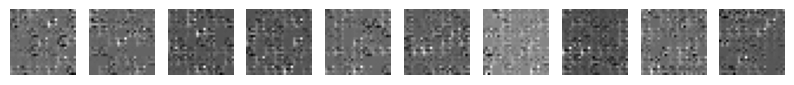

disc_loss 1.35780478 gen_loss 1.27377653 ssim 0.9844926
disc_loss 1.39010859 gen_loss 1.24640465 ssim 0.98418808
disc_loss 1.33050251 gen_loss 1.247334 ssim 0.978458047
disc_loss 1.34764993 gen_loss 1.28949726 ssim 0.980682552
disc_loss 1.3301127 gen_loss 1.29028499 ssim 0.981450737
Epoch 10/20000
1/1 [==============================] - 0s 34ms/step


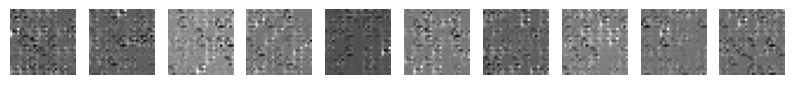

disc_loss 1.300879 gen_loss 1.2684772 ssim 0.980542958
disc_loss 1.3228426 gen_loss 1.27858126 ssim 0.982249737
disc_loss 1.31451631 gen_loss 1.32807052 ssim 0.981428564
disc_loss 1.29080009 gen_loss 1.32960439 ssim 0.978884518
disc_loss 1.33619857 gen_loss 1.3394953 ssim 0.97751826
Epoch 15/20000
1/1 [==============================] - 0s 36ms/step


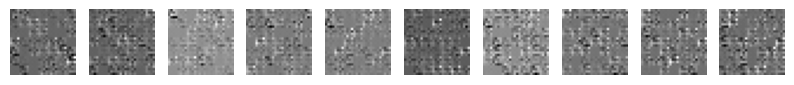

disc_loss 1.24820697 gen_loss 1.39600074 ssim 0.977032483
disc_loss 1.2507441 gen_loss 1.44857812 ssim 0.97596854
disc_loss 1.2275002 gen_loss 1.47137034 ssim 0.975432098
disc_loss 1.25182152 gen_loss 1.53764272 ssim 0.976229191
disc_loss 1.16090882 gen_loss 1.63059831 ssim 0.975261688
Epoch 20/20000
1/1 [==============================] - 0s 61ms/step


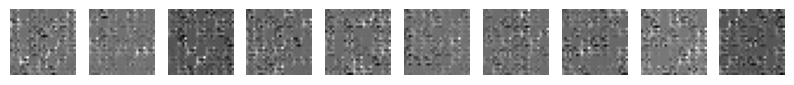

disc_loss 1.10500026 gen_loss 1.75135577 ssim 0.971761882
disc_loss 1.06549418 gen_loss 1.88838935 ssim 0.971776128
disc_loss 1.0678798 gen_loss 1.95236647 ssim 0.964594781
disc_loss 1.02707279 gen_loss 2.17060661 ssim 0.965355515
disc_loss 0.9691872 gen_loss 2.18541551 ssim 0.96822685
Epoch 25/20000
1/1 [==============================] - 0s 40ms/step


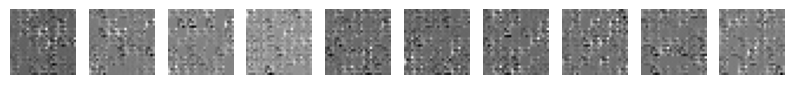

disc_loss 0.929585397 gen_loss 2.35931 ssim 0.96522963
disc_loss 0.862298191 gen_loss 2.51116228 ssim 0.966963
disc_loss 0.849855304 gen_loss 2.45164084 ssim 0.967043579
disc_loss 0.748760879 gen_loss 2.80395246 ssim 0.957745969
disc_loss 0.711850405 gen_loss 2.52755141 ssim 0.96715641
Epoch 30/20000
1/1 [==============================] - 0s 30ms/step


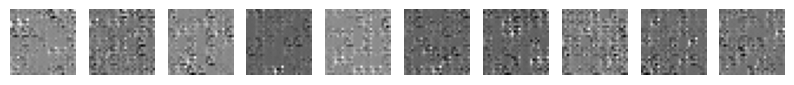

disc_loss 0.694684 gen_loss 2.88490629 ssim 0.95722717
disc_loss 0.692300916 gen_loss 3.08606625 ssim 0.957315743
disc_loss 0.583877444 gen_loss 2.92852235 ssim 0.964149773
disc_loss 0.634275079 gen_loss 3.16494131 ssim 0.958256662
disc_loss 0.542631745 gen_loss 3.48426247 ssim 0.954039514
Epoch 35/20000
1/1 [==============================] - 0s 39ms/step


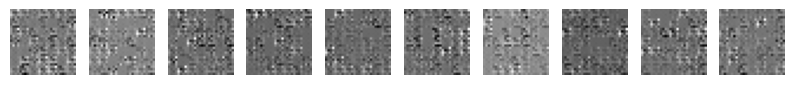

disc_loss 0.536758065 gen_loss 3.44903946 ssim 0.951306343
disc_loss 0.427040756 gen_loss 3.57701039 ssim 0.958396912
disc_loss 0.331366 gen_loss 3.97008491 ssim 0.959791303
disc_loss 0.376760751 gen_loss 3.71265578 ssim 0.952399552
disc_loss 0.309336066 gen_loss 4.06418705 ssim 0.951085269
Epoch 40/20000
1/1 [==============================] - 0s 33ms/step


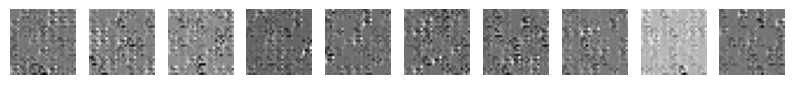

disc_loss 0.228906274 gen_loss 4.2559371 ssim 0.946305573
disc_loss 0.207485542 gen_loss 4.54104948 ssim 0.94555968
disc_loss 0.175345 gen_loss 4.4346633 ssim 0.950281441
disc_loss 0.164418966 gen_loss 4.3443675 ssim 0.950352609
disc_loss 0.133565292 gen_loss 4.50161266 ssim 0.946225107
Epoch 45/20000
1/1 [==============================] - 0s 32ms/step


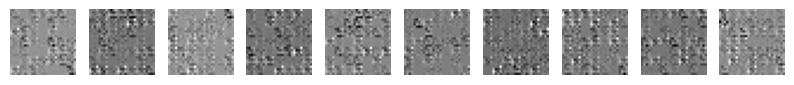

disc_loss 0.137019262 gen_loss 4.61970377 ssim 0.948150814
disc_loss 0.118047923 gen_loss 4.6651206 ssim 0.941277206
disc_loss 0.116335012 gen_loss 5.01518726 ssim 0.937049687
disc_loss 0.0853332356 gen_loss 5.11989403 ssim 0.938978195
disc_loss 0.0797832906 gen_loss 5.43569231 ssim 0.947428524
Epoch 50/20000
1/1 [==============================] - 0s 44ms/step


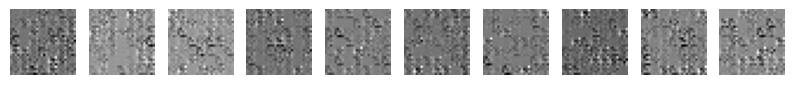

disc_loss 0.0656795204 gen_loss 4.93708086 ssim 0.927649796
disc_loss 0.0710002631 gen_loss 5.35693359 ssim 0.933477104
disc_loss 0.0753662586 gen_loss 5.18950081 ssim 0.930646539
disc_loss 0.0482405275 gen_loss 5.64269876 ssim 0.939400136
disc_loss 0.0447817296 gen_loss 5.28296137 ssim 0.922449529
Epoch 55/20000
1/1 [==============================] - 0s 40ms/step


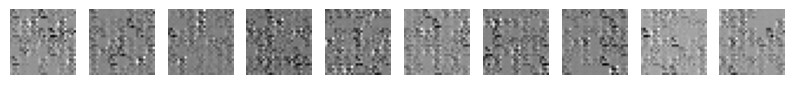

disc_loss 0.0513646752 gen_loss 5.46532822 ssim 0.938022554
disc_loss 0.0449875519 gen_loss 6.09763145 ssim 0.951974809
disc_loss 0.0457259379 gen_loss 5.58661652 ssim 0.932886541
disc_loss 0.0675561 gen_loss 6.17871475 ssim 0.928964317
disc_loss 0.040522784 gen_loss 5.94364 ssim 0.924975812
Epoch 60/20000
1/1 [==============================] - 0s 49ms/step


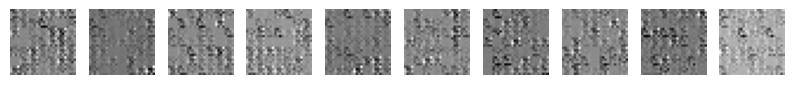

disc_loss 0.0288557075 gen_loss 6.12080812 ssim 0.928993642
disc_loss 0.0264339149 gen_loss 6.05329943 ssim 0.912596345
disc_loss 0.043191161 gen_loss 6.62920761 ssim 0.928211689
disc_loss 0.0218956601 gen_loss 6.50378609 ssim 0.928644657
disc_loss 0.0234018192 gen_loss 6.3621707 ssim 0.913850129
Epoch 65/20000
1/1 [==============================] - 0s 30ms/step


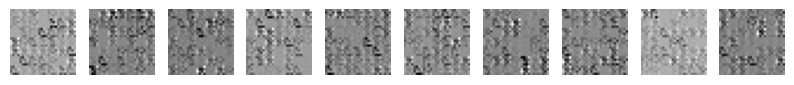

In [ ]:
@tf.function
def train_step(images, labels,num_unrolling_steps):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 28, 28, 1])

    for _ in range(num_unrolling_steps):
        with tf.GradientTape() as disc_tape:
            generated_images = generator([noise, labels], training=True)

            real_output = discriminator([images, labels], training=True)
            fake_output = discriminator([generated_images, labels], training=True)

            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator([noise, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        ssim = compute_ssim(generated_images[:5])
        gen_loss = generator_loss(fake_output)+(ssim*.5)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss,'ssim',ssim)
def train(generator, discriminator, gan, epochs, batch_size,num_unrolling_steps):
    for epoch in range(epochs):
        for batch in range(len(x_train2) // batch_size):
            images = x_train2[batch * batch_size: (batch+1) * batch_size]
            labels = y_train2[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels,num_unrolling_steps)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            # Generate and save sample images
            noise = tf.random.normal([10, 28, 28, 1])
            sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
            generated_images = generator.predict([noise, sampled_labels])
            generated_images = generated_images#(generated_images * 0.5) + 0.5  # Rescale images from [-1, 1] to [0, 1]
            fig, axs = plt.subplots(1, 10, figsize=(10, 10))
            for i in range(10):
                axs[i].imshow(generated_images[i], cmap="gray")
                axs[i].axis("off")
            plt.show()

# Train the GAN
EPOCHS = 20000
BATCH_SIZE = 64
num_unrolling_steps = 5  # Set the desired number of unrolling steps
train(generator, discriminator, gan, EPOCHS, BATCH_SIZE,num_unrolling_steps=num_unrolling_steps)